# Treinamento & busca pelos melhores hiperparâmetros

## Importações & inicialização do ambiente de execução

In [1]:
# Inicialização e limpenza do ambiente de execução
#!pip install keras-tuner -q
#!rm -rf Resultados
#!rm -rf sample_data
#!rm -rf dados_geracao_FV.csv
#!wget https://raw.githubusercontent.com/rafaprates/tfc_dados/main/dados_geracao_FV.csv

In [2]:
import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import Input
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import initializers

import keras_tuner as kt

import pandas as pd
import numpy as np
import random as python_random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

Código necessário para assegurar a reprodutibilidade dos resultados.
Elimina as aleatoriedades intrínsecas das ferramentas.

In [3]:
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

## Preprocessamento dos dados

In [4]:
# Ler o arquivo
dados = pd.read_csv(r"C:\Users\rafae\Documents\TFC2\TFC2\dados_geracao_FV.txt", decimal=",")
#dados = pd.read_csv("./dados_geracao_FV.txt", decimal=",")

In [5]:
# atribuindo os tipos de dados às colunas
dados['Hora'] = dados['Hora'].astype("int64")
dados['Temperatura_C'] = dados['Temperatura_C'].astype("float64")
dados['Radiancia_W_m2'] = dados['Radiancia_W_m2'].astype("float64")
dados['Temperatura_celula_C'] = dados['Temperatura_celula_C'].astype("float64")
dados['Potencia_W'] = dados['Potencia_W'].astype("float64")

# df_caracteristicas
dados_caracteristicas = dados[['Radiancia_W_m2', 
                         'Temperatura_celula_C', 
                         'Temperatura_C']]

# df_alvo
dados_alvo = dados[['Potencia_W']]

Comprimir os valores entre 0 e 1 para conversão mais rápida. 

**Este passo é indicado por diversas fontes.**

In [6]:
# Comprimir os valores entre 0 e 1 para conversão mais rápida.
# Este passo é indicado por diversas bibliografias.
scaler = MinMaxScaler()
caracteristicas_scaled = scaler.fit_transform(dados_caracteristicas)
alvo_scaled = scaler.fit_transform(dados_alvo)

Criar os subconjuntos de treinamento e teste.


In [7]:
# shuffle = false é muito importante porque da natureza ordenada dos dados 
# que compõem séries temporais
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

tamanho_conjunto_teste = 0.1 # em portcentagem

x_train, x_test, y_train, y_test = train_test_split(
    caracteristicas_scaled,
    alvo_scaled,
    test_size=tamanho_conjunto_teste,
    shuffle=False,
)

## Definição do modelo & espaço de procura dos hiperparâmetros

In [8]:
def hypermodel(hp):
    model = tf.keras.Sequential()

    # camada de entrada  
    model.add(tf.keras.Input(shape=(3,)))

    # número de camadas
    min_qtd_camada_oculta = 0
    max_qtd_camada_oculta = 8
    min_qtd_neuronio_por_camada = 1
    max_qtd_neuronio_por_camada = 12
    for camada in range(hp.Int('n_camada_oculta', min_qtd_camada_oculta, max_qtd_camada_oculta)):
        # número de neurônios na camada oculta
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'n_neuronio_camada_oculta_{camada+1}', 
                         min_value=min_qtd_neuronio_por_camada, 
                         max_value=max_qtd_neuronio_por_camada,
                         step=1),
        activation=hp.Choice(
            f'funcao_ativacao_camada_oculta_{camada+1}', 
            ['linear','relu']
        ),
            kernel_initializer=tf.keras.initializers.Ones()
        ))

    model.add(tf.keras.layers.Dense(
        units=1,
        activation='relu',
        kernel_initializer=tf.keras.initializers.Ones()
    ))

    # taxa de aprendizado
    taxa_aprendizado=hp.Choice("taxa_de_aprendizado", 
                               [1.0, 0.1, 0.01, 0.001]
    )

    # função de perda
    loss=hp.Choice("função_de_perda", 
                   ['mean_absolute_error', 
                    'mean_squared_error'])

    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.SGD(learning_rate=taxa_aprendizado),
        metrics=['mean_absolute_error'],
    )

    return model

In [9]:
# https://datascience.stackexchange.com/questions/68336/what-is-max-trials-and-executions-per-trial-in-keras-tuner



tuner = kt.RandomSearch(
    hypermodel,
    objective='mean_absolute_error',
    max_trials=4096,
    executions_per_trial=1,
    project_name="Rede_Densa",
    directory="Resultados",
)

INFO:tensorflow:Reloading Oracle from existing project Resultados\Rede_Densa\oracle.json
INFO:tensorflow:Reloading Tuner from Resultados\Rede_Densa\tuner0.json


Resumo do espaço de procura

In [10]:
tuner.search(x_train, 
             y_train,
             epochs=100, 
             validation_data=(x_test, y_test),
             validation_split=0.1,
             verbose=0,
             shuffle=False,
             )

INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary(num_trials=5)

Results summary
Results in Resultados\Rede_Densa
Showing 5 best trials
Trial summary
Hyperparameters:
n_camada_oculta: 0
taxa_de_aprendizado: 0.1
função_de_perda: mean_squared_error
n_neuronio_camada_oculta_1: 2
funcao_ativacao_camada_oculta_1: linear
n_neuronio_camada_oculta_2: 4
funcao_ativacao_camada_oculta_2: linear
n_neuronio_camada_oculta_3: 11
funcao_ativacao_camada_oculta_3: linear
n_neuronio_camada_oculta_4: 6
funcao_ativacao_camada_oculta_4: relu
n_neuronio_camada_oculta_5: 5
funcao_ativacao_camada_oculta_5: linear
n_neuronio_camada_oculta_6: 10
funcao_ativacao_camada_oculta_6: relu
n_neuronio_camada_oculta_7: 10
funcao_ativacao_camada_oculta_7: relu
Score: 0.0012813707580789924
Trial summary
Hyperparameters:
n_camada_oculta: 1
taxa_de_aprendizado: 0.1
função_de_perda: mean_absolute_error
n_neuronio_camada_oculta_1: 11
funcao_ativacao_camada_oculta_1: linear
n_neuronio_camada_oculta_2: 11
funcao_ativacao_camada_oculta_2: relu
n_neuronio_camada_oculta_3: 3
funcao_ativacao_cama

## Resultados

Pega-se os 3 (três) melhores modelos e guarda seus resultados

In [16]:
# construção do df_resultado
potencia_esperada = scaler.inverse_transform(y_test)
resultado = pd.DataFrame(potencia_esperada, columns=['Potência Esperada'])
resultado['Potência Esperada'] = potencia_esperada

# melhores modelos
qtd_melhores_modelos=5
models = tuner.get_best_models(num_models=qtd_melhores_modelos)

maes = dict()

for model, model_num in zip(models, range(qtd_melhores_modelos)):
   test_prediction = model.predict(x_test)
   potencia_prevista = scaler.inverse_transform(test_prediction)
   resultado[f'Potência Prevista {model_num+1}'] = potencia_prevista

   maes[f'modelo_{model_num}'] = mean_absolute_error(
       resultado['Potência Esperada'],
       resultado[f'Potência Prevista {model_num+1}']
   )

3/3 [==============================] - 0s 1ms/step


Potência Esperada e Potências Previstas dos modelos testados

Mean Absolute Error dos três melhores modelos.

In [17]:
maes
#25, 49, 51
# 5, 1116, 667

{'modelo_0': 3.9480678965939586,
 'modelo_1': 72.69033679864378,
 'modelo_2': 64.27048088275089,
 'modelo_3': 47.3409390521666,
 'modelo_4': 162.14332729736014}

Gráfico comparativo das potências previstas e esperadas

Descrição dos melhores modelos

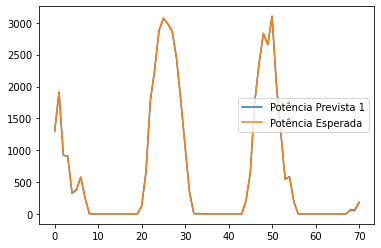

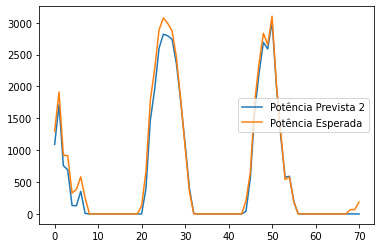

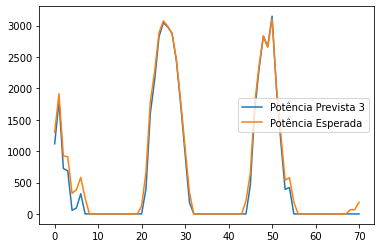

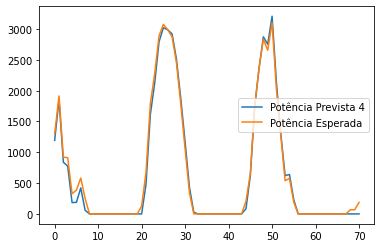

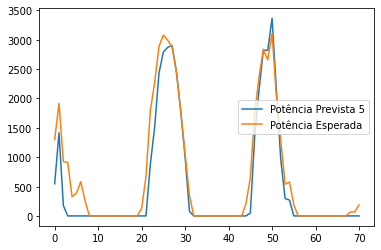

In [19]:
for num_modelo in range(qtd_melhores_modelos):
    resultado[[f'Potência Prevista {num_modelo+1}', 'Potência Esperada']].plot()

In [15]:
tuner.results_summary(num_trials=qtd_melhores_modelos)

Results summary
Results in Resultados\Rede_Densa
Showing 3 best trials
Trial summary
Hyperparameters:
n_camada_oculta: 0
taxa_de_aprendizado: 0.1
função_de_perda: mean_squared_error
n_neuronio_camada_oculta_1: 2
funcao_ativacao_camada_oculta_1: linear
n_neuronio_camada_oculta_2: 4
funcao_ativacao_camada_oculta_2: linear
n_neuronio_camada_oculta_3: 11
funcao_ativacao_camada_oculta_3: linear
n_neuronio_camada_oculta_4: 6
funcao_ativacao_camada_oculta_4: relu
n_neuronio_camada_oculta_5: 5
funcao_ativacao_camada_oculta_5: linear
n_neuronio_camada_oculta_6: 10
funcao_ativacao_camada_oculta_6: relu
n_neuronio_camada_oculta_7: 10
funcao_ativacao_camada_oculta_7: relu
Score: 0.0012813707580789924
Trial summary
Hyperparameters:
n_camada_oculta: 1
taxa_de_aprendizado: 0.1
função_de_perda: mean_absolute_error
n_neuronio_camada_oculta_1: 11
funcao_ativacao_camada_oculta_1: linear
n_neuronio_camada_oculta_2: 11
funcao_ativacao_camada_oculta_2: relu
n_neuronio_camada_oculta_3: 3
funcao_ativacao_cama